In [1]:
!mkdir dichasus
!wget --content-disposition https://darus.uni-stuttgart.de/api/access/datafile/:persistentId?persistentId=doi:10.18419/darus-2202/2 -P dichasus # dichasus-0152
!wget --content-disposition https://darus.uni-stuttgart.de/api/access/datafile/:persistentId?persistentId=doi:10.18419/darus-2202/3 -P dichasus # dichasus-0153

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def record_parse_function(proto):
	record = tf.io.parse_single_example(proto, {
		"csi": tf.io.FixedLenFeature([], tf.string, default_value = ""),
		"pos-tachy": tf.io.FixedLenFeature([], tf.string, default_value = "")
	})
	csi = tf.ensure_shape(tf.io.parse_tensor(record["csi"], out_type = tf.float32), (32, 1024, 2))
	pos_tachy = tf.ensure_shape(tf.io.parse_tensor(record["pos-tachy"], out_type = tf.float64), (3))

	dist = tf.sqrt(tf.square(pos_tachy[0]) + tf.square(pos_tachy[1]))
	angle = tf.math.atan2(pos_tachy[1], -pos_tachy[0])

	return csi, pos_tachy[:2], angle, dist

def get_feature_mapping(chunksize = 32):
	def compute_features(csi, pos_tachy, angle, dist):
		assert(csi.shape[1] % chunksize == 0)
		featurecount = csi.shape[1] // chunksize
		csi_averaged = tf.stack([tf.math.reduce_mean(csi[:, (chunksize * s):(chunksize * (s + 1)), :], axis = 1) for s in range(featurecount)], axis = 1)
		return csi_averaged, pos_tachy, angle, dist

	return compute_features

datafiles = ["dichasus/dichasus-0152.tfrecords", "dichasus/dichasus-0153.tfrecords"]
dataset = tf.data.TFRecordDataset(datafiles).map(record_parse_function)

training_set = dataset.filter(lambda csi, pos, angle, dist: dist <= 4 and dist > 0.5)
test_set = dataset.filter(lambda csi, pos, angle, dist: dist > 4)

training_set_features = training_set.map(get_feature_mapping(32))
test_set_features = test_set.map(get_feature_mapping(32))

training_set_features = training_set_features.shuffle(buffer_size = 100000).cache()
test_set_features = test_set_features.shuffle(buffer_size = 100000).cache()

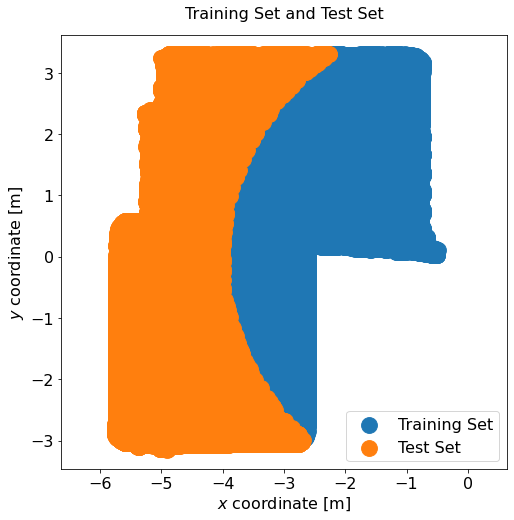

In [4]:
positions_train = np.vstack([pos for csi, pos, angle, dist in training_set_features])
positions_test = np.vstack([pos for csi, pos, angle, dist in test_set_features])

plt.figure(figsize = (8, 8))
plt.title("Training Set and Test Set", fontsize = 16, pad = 16)
plt.axis("equal")
plt.xlim(-6, 0)
plt.scatter(x = positions_train[:,0], y = positions_train[:,1], marker = ".", s = 1000, label = "Training Set")
plt.scatter(x = positions_test[:,0], y = positions_test[:,1], marker = ".", s = 1000, label = "Test Set")
plt.legend(fontsize = 16)
plt.xlabel("$x$ coordinate [m]", fontsize = 16)
plt.ylabel("$y$ coordinate [m]", fontsize = 16)
plt.tick_params(axis = "both", labelsize = 16)
plt.show()

In [10]:
nn_input = tf.keras.Input(shape=(32, 32, 2), name = "input")
nn_output = tf.keras.layers.Flatten()(nn_input)

nn_output = tf.keras.layers.Dense(units = 64, activation = "relu")(nn_output)
nn_output = tf.keras.layers.Dense(units = 64, activation = "relu")(nn_output)
nn_output = tf.keras.layers.Dense(units = 64, activation = "relu")(nn_output)
nn_output = tf.keras.layers.Dense(units = 1, activation = "linear", name = "output")(nn_output)
model = tf.keras.Model(inputs = nn_input, outputs = nn_output, name = "AoA_NN")
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = "mse")

def only_input_output(csi, pos, angle, dist):
	return csi, angle

batch_sizes = [32, 64, 256, 1024, 4096]
for b in batch_sizes:
	dataset_batched = training_set_features.batch(b)
	test_set_batched = test_set_features.batch(b)
	print("\nBatch Size:", b)
	model.fit(dataset_batched.map(only_input_output), epochs = 10, validation_data = test_set_batched.map(only_input_output))


Batch Size: 32
Epoch 1/10
367/367 [==============================] - 1s 3ms/step - loss: 0.7277 - val_loss: 0.1197
Epoch 2/10
367/367 [==============================] - 1s 3ms/step - loss: 0.1833 - val_loss: 0.0970
Epoch 3/10
367/367 [==============================] - 1s 3ms/step - loss: 0.1168 - val_loss: 0.0892
Epoch 4/10
367/367 [==============================] - 1s 3ms/step - loss: 0.0867 - val_loss: 0.0752
Epoch 5/10
367/367 [==============================] - 1s 3ms/step - loss: 0.0687 - val_loss: 0.0687
Epoch 6/10
367/367 [==============================] - 1s 3ms/step - loss: 0.0529 - val_loss: 0.0710
Epoch 7/10
367/367 [==============================] - 1s 3ms/step - loss: 0.0449 - val_loss: 0.0868
Epoch 8/10
367/367 [==============================] - 1s 3ms/step - loss: 0.0408 - val_loss: 0.0511
Epoch 9/10
367/367 [==============================] - 1s 3ms/step - loss: 0.0352 - val_loss: 0.0601
Epoch 10/10
367/367 [==============================] - 1s 3ms/step - loss: 0.0321 - 

In [11]:
positions = []
predicted_angles = []
true_angles = []
distances = []

for csi, pos, angle, dist in test_set_features.batch(100):
	positions.append(pos.numpy())
	predicted_angles.append(np.transpose(model.predict(csi))[0])
	true_angles.append(angle.numpy())
	distances.append(dist.numpy())

positions = np.vstack(positions)
predicted_angles = np.hstack(predicted_angles)
true_angles = np.hstack(true_angles)
distances = np.hstack(distances)

errorvectors = np.transpose(distances * np.vstack([-np.cos(predicted_angles), np.sin(predicted_angles)])) - positions
errors_abs_deg = np.rad2deg(np.abs(true_angles - predicted_angles))

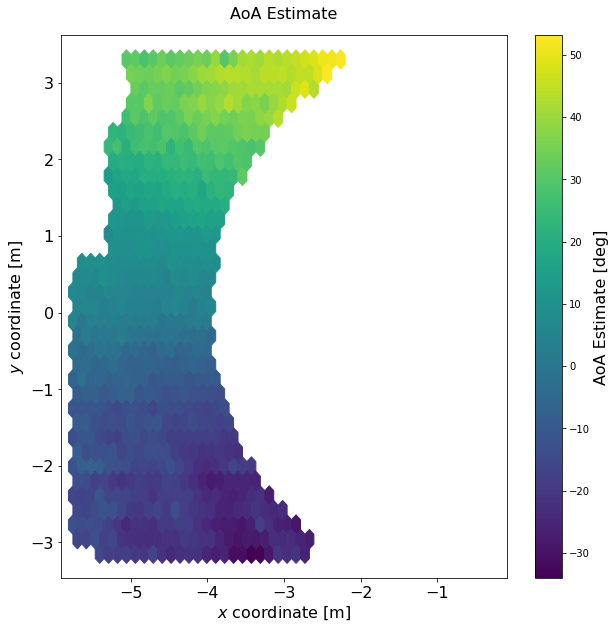

In [12]:
plt.figure(figsize=(10, 10))
plt.title("AoA Estimate", fontsize = 16, pad = 16)

plt.axis("equal")
plt.xlim(-6, 0)
plt.hexbin(x = positions[:, 0], y = positions[:, 1], C = np.rad2deg(predicted_angles), gridsize = 30)
cb = plt.colorbar()
cb.set_label("AoA Estimate [deg]", fontsize = 16)
plt.xlabel("$x$ coordinate [m]", fontsize = 16)
plt.ylabel("$y$ coordinate [m]", fontsize = 16)
plt.tick_params(axis = "both", labelsize = 16)
plt.show()

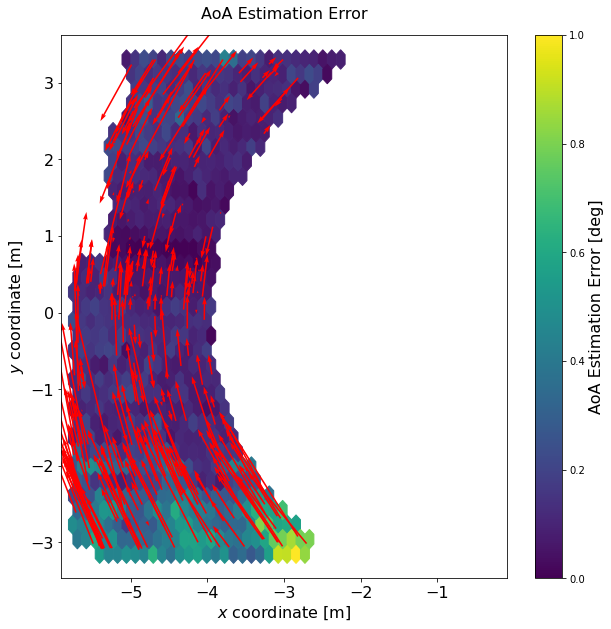

In [13]:
plt.figure(figsize=(10, 10))
plt.title("AoA Estimation Error", fontsize = 16, pad = 16)

plt.axis("equal")
plt.xlim(-6, 0)
plt.hexbin(x = positions[:, 0], y = positions[:, 1], C = errors_abs_deg, gridsize = 30)
plt.quiver(positions[:300, 0], positions[:300, 1], errorvectors[:300, 0], errorvectors[:300, 1], color = "red", angles = "xy", scale_units = "xy", scale = 1)

cb = plt.colorbar()
cb.set_label("AoA Estimation Error [deg]", fontsize = 16)
plt.xlabel("$x$ coordinate [m]", fontsize = 16)
plt.ylabel("$y$ coordinate [m]", fontsize = 16)
plt.tick_params(axis = "both", labelsize = 16)
plt.show()

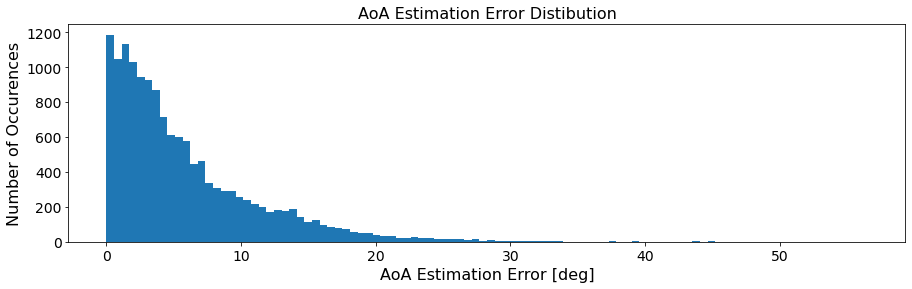

In [14]:
plt.figure(figsize=(15, 4))
plt.title("AoA Estimation Error Distibution", fontsize = 16)
plt.xlabel("AoA Estimation Error [deg]", fontsize = 16)
plt.ylabel("Number of Occurences", fontsize = 16)
plt.tick_params(axis = "both", labelsize = 14)
		
plt.hist(errors_abs_deg, bins = 100)
plt.show()